In [1]:
using ModelingToolkit
using DifferentialEquations
using Plots
using ModelingToolkit: t_nounits as t, D_nounits as D, @variables, @parameters, @named, @unpack, @mtkbuild
using Symbolics

In [2]:
mutable struct Wall
    rho::Float64
    V::Float64
    m::Float64
    Cp::Float64
    m_elem::Float64
end
mutable struct Ref
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    Ge1::Float64
    Ge2::Float64
end
mutable struct Fld
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    k::Float64
    Pr::Float64
    rho::Float64
    mu::Float64
    Cp::Float64
    mdot::Float64
    T_in::Float64
end
mutable struct HX_PHX
    N_t::Int64
    N_c::Int64
    N_f::Int64
    L_w::Float64
    L_v::Float64
    A_t::Float64
    phi::Float64
    p::Float64
    t::Float64
    b::Float64
    D_h::Float64
    beta::Float64
    N_CV::Int64
    Wall::Wall
    Ref::Ref
    Fld::Fld
    isCounterFlow::Bool
end

In [3]:
function make_HX(N_t::Int64, L_w::Float64, L_v::Float64, A_t::Float64, p::Float64, t::Float64, N_CV::Int64, isCounterFlow::Bool)
    # DIC-193-33 PHX. http://www.dibr.co.kr/exchanger/detail/D93RP00056?ts=1735978818&capacity=0.5&cate=162&
    N_t = N_t
    N_c = (N_t - 1) / 2
    N_f = (N_t - 1) / 2
    L_w = L_w
    L_v = L_v
    A_t = A_t
    phi = A_t / (L_w * L_v * (N_t - 2))
    p = p
    t = t
    b = p - t 
    D_h = 2 * b / phi
    beta = 25 * pi / 180
    N_CV = N_CV

    # Wall Geo, Props
    Wall_rho = 7.93e3 # STS 304 밀도
    Wall_V = A_t * t
    Wall_m = Wall_V * Wall_rho
    Wall_Cp = 502 # 비열

    # Ref, Fld Geo
    Ref_V = N_c * L_w * b* L_v
    Ref_A_cs = N_c * L_w * b
    Fld_V =  N_f * L_w * b * L_v
    Fld_A_cs = N_f * L_w * b

    # Geo per Element
    Wall_m_elem = Wall_m / N_CV
    Ref_V_elem = Ref_V / N_CV
    Ref_A_elem = A_t / N_CV
    Fld_V_elem = Fld_V / N_CV
    Fld_A_elem = Ref_A_elem

    # Ref UA Props
    Ref_Ge1 = 11.22*(b/D_h)^(-2.83) * (pi/2 - beta)^(-4.5)
    Ref_Ge2 = 0.35*(b/D_h)^(0.23) * (pi/2 - beta)^(1.48)

    # Fld Props (Water, 15C, Saturated Liquid, refprop)
    Fld_k = 0.5887
    Fld_Pr = 1.7058
    Fld_rho = 999.0561
    Fld_mu = 0.0011
    Fld_Cp = 4.1888e3

    # Fld
    Fld_mdot = 0.1
    Fld_T_in = 273.15 + 40
    isCounterFlow = isCounterFlow

    HX_Wall = Wall(Wall_rho, Wall_V, Wall_m, Wall_Cp, Wall_m_elem)
    HX_Ref = Ref(Ref_V, Ref_A_cs, Ref_V_elem, Ref_A_elem, Ref_Ge1, Ref_Ge2)
    HX_Fld = Fld(Fld_V, Fld_A_cs, Fld_V_elem, Fld_A_elem, Fld_k, Fld_Pr, Fld_rho, Fld_mu, Fld_Cp, Fld_mdot, Fld_T_in)
    return HX_PHX(N_t, N_c, N_f, L_w, L_v, A_t, phi, p, t, b, D_h, beta, N_CV, HX_Wall, HX_Ref, HX_Fld, isCounterFlow)
end
# HX_C
HX_C_N_t = 33
HX_C_L_w = 0.083
HX_C_L_v = 0.154
HX_C_A_t = 0.434
HX_C_p = 2.35e-3
HX_C_t = 0.4e-3
HX_C_N_CV = 20
HX_C_isCounterFlow = true
HX_C = make_HX(HX_C_N_t, HX_C_L_w, HX_C_L_v, HX_C_A_t, HX_C_p, HX_C_t, HX_C_N_CV, HX_C_isCounterFlow)

HX_PHX(33, 16, 16, 0.083, 0.154, 0.434, 1.095290251916758, 0.00235, 0.0004, 0.0019500000000000001, 0.0035607, 0.4363323129985824, 20, Wall(7930.0, 0.00017360000000000002, 1.376648, 502.0, 0.0688324), Ref(0.0003987984000000001, 0.0025896000000000005, 1.9939920000000003e-5, 0.0217, 34.95278503589673, 0.3672934117781399), Fld(0.0003987984000000001, 0.0025896000000000005, 1.9939920000000003e-5, 0.0217, 0.5887, 1.7058, 999.0561, 0.0011, 4188.8, 0.1, 313.15), true)

In [4]:
# Q11. MTK ver
using CoolProp
# CoolProp with MTK (Tabular / Consider to change into PINN)
 # ρ, T from P, h
handle = CoolProp.AbstractState_factory("HEOS&BICUBIC", "R410A")

function R410a_density(P, h)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("HmassP_INPUTS"), h, P)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end

function R410a_temperature(P, h)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("HmassP_INPUTS"), h, P)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("T"))
end

# Q  = 0, 1 // Q = 0 Props of Ref
function R410a_h_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Hmass"))
end
function R410a_h_V(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Hmass"))
end
function R410a_rho_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end
function R410a_rho_V(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Dmass"))
end

function R410a_k_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("L"))
end
function R410a_mu_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("V"))
end
function R410a_Pr_L(P)
    CoolProp.AbstractState_update(handle, CoolProp.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CoolProp.AbstractState_keyed_output(handle, CoolProp.get_param_index("Prandtl"))
end

R410a_x(P,h) = (h - R410a_h_L(P)) / (R410a_h_V(P) - R410a_h_L(P))

# Symbolics
@register_symbolic R410a_density(P, h) 
@register_symbolic R410a_temperature(P, h)

@register_symbolic R410a_h_L(P)
@register_symbolic R410a_h_V(P)
@register_symbolic R410a_rho_L(P)
@register_symbolic R410a_rho_V(P)

@register_symbolic R410a_k_L(P)
@register_symbolic R410a_mu_L(P)
@register_symbolic R410a_Pr_L(P)

@register_symbolic R410a_x(P, h)

# Symbolics_Der
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{1}) = R410a_density(args[1]+1, args[2]) -  R410a_density(args[1], args[2])
Symbolics.derivative(::typeof(R410a_density), args::NTuple{2,Any}, ::Val{2}) = R410a_density(args[1], args[2]+1) -  R410a_density(args[1], args[2])

In [5]:
# Func for UA_elem
function U_func(P, h, mdot_in, HX_Arr)
    x = R410a_x(P, h)
    ref_k_L = R410a_k_L(P)
    ref_mu_L = R410a_mu_L(P)
    ref_Pr_L = R410a_Pr_L(P)
    ref_rho_L = R410a_rho_L(P)
    ref_rho_V = R410a_rho_V(P)
    
    HX_D_h = HX_Arr[1]
    HX_beta = HX_Arr[2]
    HX_Ref_A_cs = HX_Arr[3]
    HX_Ref_Ge1 = HX_Arr[4]
    HX_Ref_Ge2 = HX_Arr[5]

    # Single phase 
    G = ifelse(mdot_in > 0, mdot_in / HX_Ref_A_cs, 0)
    Re_L = G * HX_D_h / ref_mu_L
    U_ref_single = 0.295 * (ref_k_L/HX_D_h) * Re_L^0.64 * ref_Pr_L^0.32 * (π/2 - HX_beta)^0.09

    # Two phase
    G_eq_tp = G * (1-x + x*(ref_rho_L/ref_rho_V)^0.5)
    Re_eq_tp = G_eq_tp * HX_D_h / ref_mu_L
    U_ref_tp = HX_Ref_Ge1 * (ref_k_L/HX_D_h) * Re_eq_tp^HX_Ref_Ge2 * ref_Pr_L^(1/3)
   
    slope1 = (U_ref_tp - U_ref_single) / 0.1
    slope2 = (U_ref_single - U_ref_tp) / 0.1 # slope2는 -slope1과 같음

    # Smoothing with ifelse
    U_ref = U_ref_single +
            ifelse(x > 0.0, slope1 * (x - 0.0), 0) +      # x=0에서 기울기 0 -> slope1로 증가
            ifelse(x > 0.1, -slope1 * (x - 0.1), 0) +     # x=0.1에서 기울기 slope1 -> 0으로 감소
            ifelse(x > 0.9, slope2 * (x - 0.9), 0) +      # x=0.9에서 기울기 0 -> slope2로 증가
            ifelse(x > 1.0, -slope2 * (x - 1.0), 0)       # x=1.0에서 기울기 slope2 -> 0으로 감소

    return U_ref
end

U_func (generic function with 1 method)

In [6]:
@register_symbolic U_func(P, h, mdot_in, HX_Arr::Symbolics.Arr{Num,5})

In [7]:
# Fld UA_elem calc / Const
function U_func_Fld(HX::HX_PHX)
    G = HX.Fld.mdot / HX.Fld.A_cs
    Re_Fld = G * HX.D_h / HX.Fld.mu
    U_ref_Fld = 0.295 * (HX.Fld.k/HX.D_h) * Re_Fld^0.64 * HX.Fld.Pr^0.32 * (π/2 - HX.beta)^0.09
    return U_ref_Fld
end

U_func_Fld (generic function with 1 method)

In [8]:
# 1. Params, Variables for Ref
N = HX_C.N_CV
U_Fld_elem = U_func_Fld(HX_C)

# Init Props
P_in_val = 3200e3
P_out_val = 3000e3
h_in_val = 450e3
c1_val = 9e-6
c2_val = c1_val

9.0e-6

In [ ]:
# 1. Params for HX
# 1-0. Init cond
@parameters begin
    c1=c1_val 
    c2=c2_val
    P_in=P_in_val
    P_out=P_out_val
    h_init=h_in_val 
    ρ_init=R410a_density(P_in_val, h_in_val)
    eps = 1e3

end

# 1-1. Ref side
@parameters begin
    HX_Arr[1:5] = [HX_C.D_h, HX_C.beta, HX_C.Ref.A_cs, HX_C.Ref.Ge1, HX_C.Ref.Ge2]
    HX_Ref_A_elem = HX_C.Ref.A_elem
    HX_Ref_V_elem = HX_C.Ref.V_elem
end
# 1-2. Wall Side
@parameters begin
    HX_Wall_m_elem = HX_C.Wall.m_elem
    HX_Wall_Cp = HX_C.Wall.Cp
end
# 1-3. Fld Side
@parameters begin
    HX_Fld_mdot_in = HX_C.Fld.mdot
    HX_Fld_T_in = HX_C.Fld.T_in
    HX_Fld_A_elem = HX_C.Fld.A_elem
    HX_Fld_Cp = HX_C.Fld.Cp
    UA_Fld_elem = U_Fld_elem * HX_C.Fld.A_elem # UA const for Fld side
end

# 2. Variables for HX
# 2-1. Ref Side
    # Static
@variables begin
    P(t) = P_in_val
    h(t)[1:N] = h_in_val*ones(N) 
    ρ(t)[1:N]
    T(t)[1:N]
    UA_elem(t)[1:N]
end
    # Flow
@variables begin
    mdot_in(t)[1:N] 
    mdot_out(t)[1:N]
    h_in(t)[1:N]
    h_out(t)[1:N]
    H_in(t)[1:N]
    H_out(t)[1:N]
    Q_r(t)[1:N]
end
# 2-2. Wall Side
@variables T_wall(t)[1:N] = HX_C.Fld.T_in*ones(N)
# 2-3. Fld Side
    # Static
@variables begin
    T_Fld(t)[1:N+1]
end
    # Flow
@variables begin
    Q_f(t)[1:N]
end

1-element Vector{Symbolics.Arr{Num, 1}}:
 (Q_f(t))[1:20]

In [10]:
# 4. Equations
# 4-1. Evap
# 4-1.1 Evap_Ref_side
cond_Ref = [
    [
    # 1-1. Algebraic eqns for Ref
    # Static vars cal
    ρ[i] ~ R410a_density(P, h[i]), T[i] ~ R410a_temperature(P, h[i]),
    
    # Flow vars cal(mdot[i], h_out[i], H_in[i], H_out[i] : By Static vars P, h[i], ρ[i])
    mdot_in[i] ~ (i == 1 ? ifelse(P_in > P, c1 * sqrt(ρ_init * (P_in - P) + eps^2), c1 * eps) : mdot_out[i-1]),
    mdot_out[i] ~ (i == N ? ifelse(P > P_out, c2 * sqrt(ρ[i] * (P - P_out) + eps^2), c2 * eps) : mdot_in[i+1]),
    h_in[i] ~ (i == 1 ? h_init : h_out[i-1]),
    h_out[i] ~ h[i],
    H_in[i] ~ mdot_in[i] * h_in[i],
    H_out[i] ~ mdot_out[i] * h_out[i],
    
    # Flow vars cal(Q_r[i] : By Static vars (P, h[i], ρ[N]), T) 
    UA_elem[i] ~ U_func(P, h[i], mdot_in[i], HX_Arr) * HX_Ref_A_elem,
    Q_r[i] ~ UA_elem[i] * (T_wall[i] - T[i]),

    # 1-2. Differential eqns for Ref [Static vars diff by flow vars(mdot_in, mdot_out, h_out, Q_r)]
    HX_Ref_V_elem * D(ρ[i]) ~ mdot_in[i] - mdot_out[i],
    HX_Ref_V_elem * h[i] * D(ρ[i]) + HX_Ref_V_elem * ρ[i] * D(h[i]) - HX_Ref_V_elem * D(P) ~ H_in[i] - H_out[i] + Q_r[i],
    ]
    for i in 1:N
]

if HX_C.isCounterFlow == true
    # 4-1.2 Evap_Wall_side
    cond_Wall = [
        [
            # 2-1. Algebraic eqns for Wall
            # 2-2. Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[N+1-i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # 4-1.3 Evap_Fld_side
    cond_Fld = [
        [
            # 3-1. Algebraic eqns for Fld
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[N+1-i] - T_wall[i]),
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[N+1-i] - T_Fld[N+2-i])
        ]
        for i in 1:N
    ]
else
    # 4-1.2 Evap_Wall_side
    cond_Wall = [
        [
            # 2-1. Algebraic eqns for Wall
            # 2-2. Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # 4-1.3 Evap_Fld_side
    cond_Fld = [
        [
            # 3-1. Algebraic eqns for Fld
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[i] - T_wall[i]),
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[i+1] - T_Fld[i])
        ]
        for i in 1:N
    ]
end
push!(cond_Fld, [T_Fld[1] ~ HX_Fld_T_in])

# Flatten the evap models
cond_eqns = vcat(cond_Ref, cond_Wall, cond_Fld)
cond_model = [cond_eq for cond_eq_vec in cond_eqns for cond_eq in cond_eq_vec]

301-element Vector{Equation}:
 (ρ(t))[1] ~ Main.R410a_density(P(t), (h(t))[1])
 (T(t))[1] ~ Main.R410a_temperature(P(t), (h(t))[1])
 (mdot_in(t))[1] ~ ifelse(P_in > P(t), c1*sqrt((P_in - P(t))*ρ_init + eps^2), c1*eps)
 (mdot_out(t))[1] ~ (mdot_in(t))[2]
 (h_in(t))[1] ~ h_init
 (h_out(t))[1] ~ (h(t))[1]
 (H_in(t))[1] ~ (h_in(t))[1]*(mdot_in(t))[1]
 (H_out(t))[1] ~ (h_out(t))[1]*(mdot_out(t))[1]
 (UA_elem(t))[1] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[1], (mdot_in(t))[1], HX_Arr)
 (Q_r(t))[1] ~ (-(T(t))[1] + (T_wall(t))[1])*(UA_elem(t))[1]
 ⋮
 (Q_f(t))[4] ~ HX_Fld_Cp*HX_Fld_mdot_in*((T_Fld(t))[4] - (T_wall(t))[17])*(1 - exp((-UA_Fld_elem) / (HX_Fld_Cp*HX_Fld_mdot_in)))
 (Q_f(t))[4] ~ HX_Fld_Cp*HX_Fld_mdot_in*((T_Fld(t))[4] - (T_Fld(t))[5])
 (Q_f(t))[3] ~ HX_Fld_Cp*HX_Fld_mdot_in*((T_Fld(t))[3] - (T_wall(t))[18])*(1 - exp((-UA_Fld_elem) / (HX_Fld_Cp*HX_Fld_mdot_in)))
 (Q_f(t))[3] ~ HX_Fld_Cp*HX_Fld_mdot_in*((T_Fld(t))[3] - (T_Fld(t))[4])
 (Q_f(t))[2] ~ HX_Fld_Cp*HX_Fld_mdot_in*((T_Fld(t)

In [11]:
@mtkcompile sys = System(cond_model, t)

Model sys:
Equations (63):
  63 standard: see equations(sys)
Unknowns (63): see unknowns(sys)
  Pˍt(t)
  (T_wall(t))[1] [defaults to 313.15]
  (h(t))[1] [defaults to 450000.0]
  (h(t))[2] [defaults to 450000.0]
  ⋮
Parameters (16): see parameters(sys)
  HX_Wall_Cp [defaults to 502.0]
  HX_Fld_T_in [defaults to 313.15]
  ρ_init [defaults to 119.638]
  HX_Fld_Cp [defaults to 4188.8]
  ⋮
Observed (271): see observed(sys)

In [12]:
tspan = (0.0, 10.0)
prob = ODEProblem(sys, [], tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 10.0)
u0: 63-element Vector{Float64}:
      3.2e6
    313.15
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
 450000.0
      ⋮
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15
    313.15

In [13]:
# Rodas5P -> QNDF, FBDF -> RadauIIA5 [Stiff ODE solvers]
sol = solve(prob, Rodas5P(autodiff=false), adaptive=true)

┌ Warning: At t=8.391833021010054, dt was forced below floating point epsilon 1.7763568394002505e-15, and step error estimate = 265.78444814535567. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\Junho_Park\.julia\packages\SciMLBase\dld4W\src\integrator_interface.jl:623


retcode: Unstable
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 355-element Vector{Float64}:
 0.0
 1.0e-6
 4.239959853850982e-6
 1.6307601900200432e-5
 6.376427135355891e-5
 0.0002329491861274278
 0.0007082918910324814
 0.0015217869031991945
 0.0028343145089988926
 0.004556412831061973
 ⋮
 8.391749376091798
 8.391756624611737
 8.39176263316728
 8.391770997980748
 8.391781187812578
 8.391791691482673
 8.39180382567837
 8.391818423344212
 8.391833021010054
u: 355-element Vector{Vector{Float64}}:
 [-4.825316559028091e6, 313.15, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0, 450000.0  …  313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15, 313.15]
 [-4.825038055684688e6, 313.1500021947017, 449999.92787920736, 449999.9155624091, 449999.90561426827, 449999.8971017006, 449999.8895940025, 449999.88284665445, 449999.8767036485, 449999.87105758605  …  313.15000909314176, 313.15000888898504, 313.1500086749697, 313.1500084502

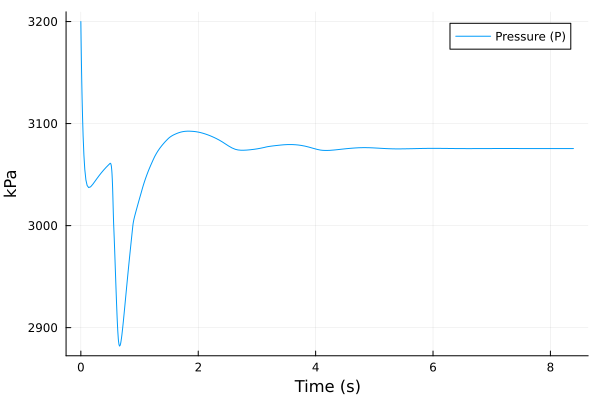

In [ ]:
function unpack_sys(sys)
    @unpack P, h, mdot_out = sys

    # 1. Vectors for P, h, mdot_out
    all_h_sols = [sol[h[i]] for i in 1:N]
    all_mdot_sols = [sol[mdot_out[i]] for i in 1:N]
    # [t, Vector(P), Vector(h1), Vector(h2), ...] Vector{Vector}
    return vcat([sol.t], [sol[P]], all_h_sols, all_mdot_sols)
end

sol_real=unpack_sys(sys)


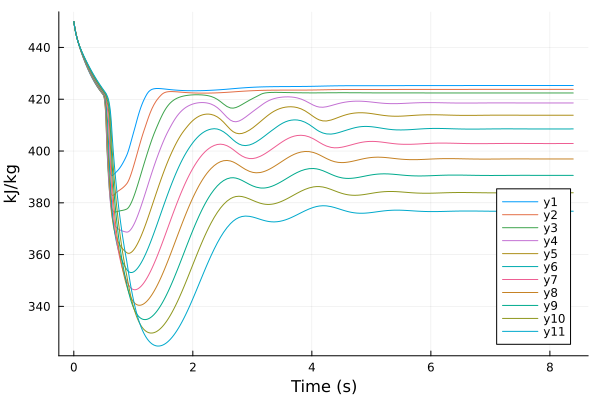

In [17]:
function plot_the_res(sol, N=N)
    # 1. Data extraction
    sol_t = sol[1]
    P_sol = sol[2]
    # h_sol : h1, h2, ... array
    h_sols = sol[3:(2+N)]
    mdot_sols = sol[(3+N):end]

    # Restrict view to t >= 0.4
    i0 = findfirst(>=(0.01), sol_t)
    i0 === nothing && (i0 = 1)
    t_view = sol_t[i0:end]
    P_view = P_sol[i0:end]

    # 2. Plot
    p1 = Plots.plot(sol_t, P_sol ./ 1e3, label="Pressure (P)", xlabel="Time (s)", ylabel="kPa")
    p2 = Plots.plot(sol_t, h_sols[10:end]./ 1e3, xlabel="Time (s)", ylabel="kJ/kg", legend=:best)
    p3 = Plots.plot(sol_t, mdot_sols[end], label="Mass Flow Rate (mdot)", xlabel="Time (s)", ylabel="kg/s")

    return p2
end
plot_the_res(sol_real)